## Improve SNR

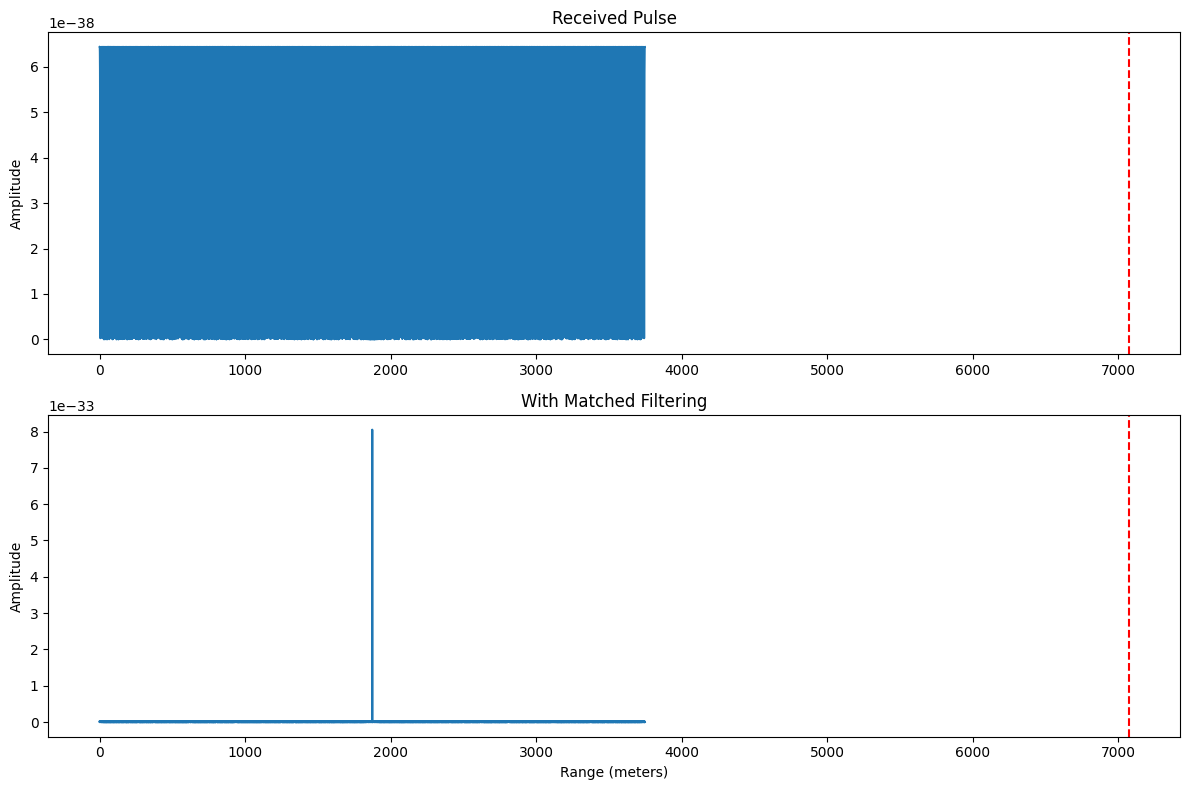

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, pi, Boltzmann
from scipy.signal import correlate, chirp

# Constants
fc = 10e9  # Carrier frequency
gain = 20  # Transmitter gain in dB
tx_loc = np.array([0, 0, 0])
tgt_loc = np.array([5000, 5000, 10])
pulse_width = 25e-6
prf = 10e3
num_pulses = 1
Ts = 290  # System temperature in Kelvin

# Calculate range and angle from transmitter to target
tgtrng = np.linalg.norm(tgt_loc - tx_loc)
tgtang = np.arctan2(tgt_loc[1], tgt_loc[0])

# Waveform generation
time = np.linspace(0, pulse_width, int(pulse_width * fc))
waveform = chirp(time, f0=0, f1=fc, t1=pulse_width, method='linear')

# Radar equation components
lambda_wave = c / fc
maxrange = c / (2 * prf)
snr = 10 * np.log10(1e-6)  # Simplified SNR calculation for threshold
db_terms = 10**(snr / 10)
Pt = (4 * pi)**3 * Boltzmann * Ts / (pulse_width * 1 / lambda_wave**2 * maxrange**4 * db_terms)  # Peak power estimate

# Simulate transmission and reception
tx_signal = waveform * Pt * 10**(gain / 10)

# Free space path loss model
def free_space_loss(signal, distance, freq):
    wavelength = c / freq
    loss = (4 * pi * distance / wavelength)**2
    return signal / loss

# Transmitting and receiving the signal
propagated_signal = free_space_loss(tx_signal, tgtrng, fc)
received_signal = propagated_signal  # Assume perfect reflection for simplicity

# Matched filtering
matched_filter = np.conj(np.flipud(waveform))
mf_output = correlate(received_signal, matched_filter, mode='same')

# Calculate range gates
sample_rate = int(fc)
gate_time = np.arange(len(received_signal)) / sample_rate
range_gates = gate_time * c / 2

# Plotting results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(range_gates, np.abs(received_signal))
plt.title('Received Pulse')
plt.ylabel('Amplitude')
plt.axvline(x=tgtrng, color='r', linestyle='--')

plt.subplot(2, 1, 2)
plt.plot(range_gates, np.abs(mf_output))
plt.title('With Matched Filtering')
plt.xlabel('Range (meters)')
plt.ylabel('Amplitude')
plt.axvline(x=tgtrng, color='r', linestyle='--')

plt.tight_layout()
plt.show()


## Matched Filter

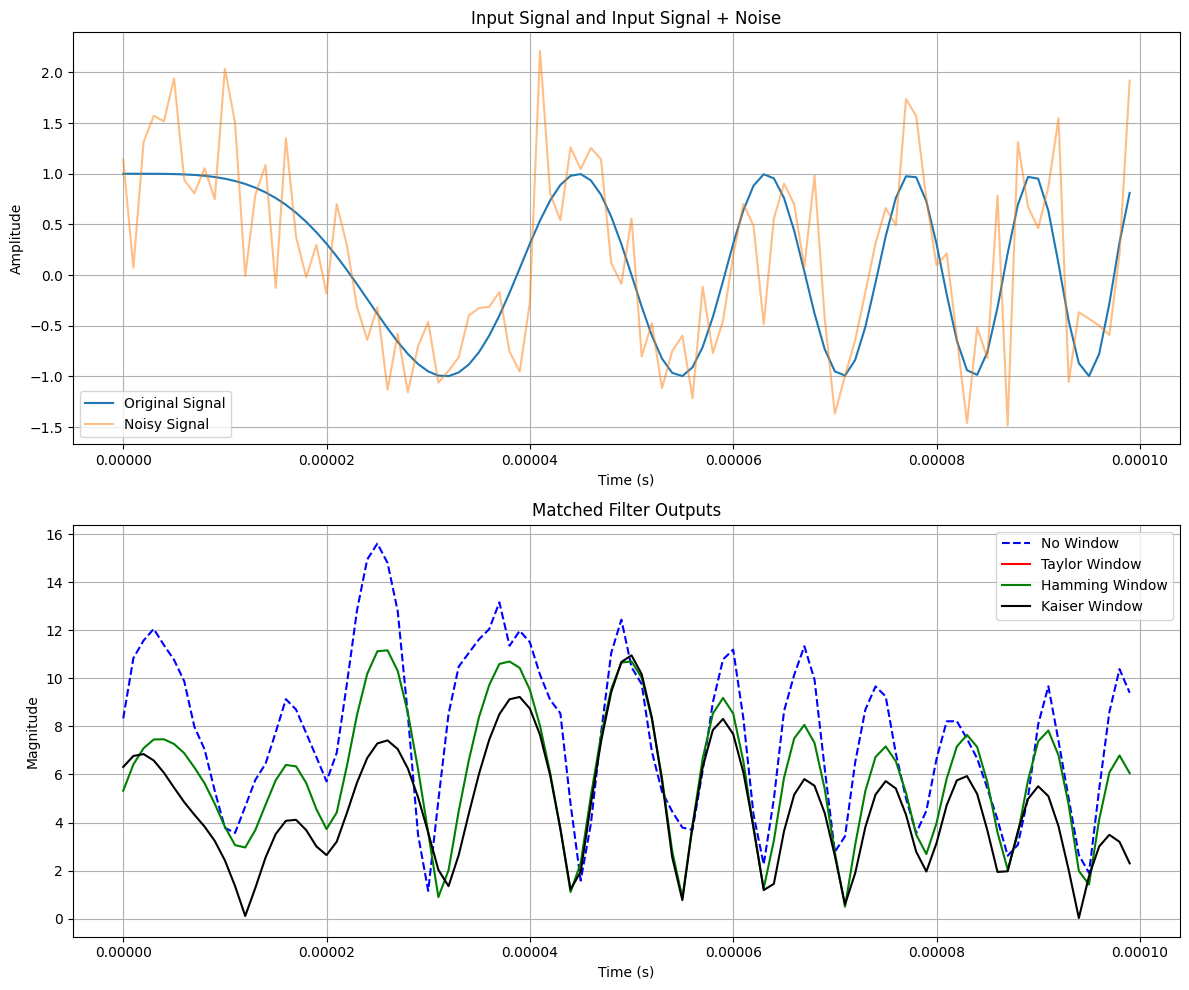

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, correlate, windows

# Parameters
pulse_width = 1e-4
prf = 5e3
sample_rate = 1e6
sweep_bandwidth = 1e5

# Time base
t = np.linspace(0, pulse_width, int(pulse_width * sample_rate), endpoint=False)

# Generate LFM waveform
signal = chirp(t, f0=0, f1=sweep_bandwidth, t1=pulse_width, method='linear')

# Get matched filter (time-reversed complex conjugate of the signal)
matched_filter_coeff = np.conj(signal[::-1])

# Define window functions for matched filter
taylor_win = windows.taylor(len(matched_filter_coeff), nbar=4, sll=-30)
hamming_win = windows.hamming(len(matched_filter_coeff))
kaiser_win = windows.kaiser(len(matched_filter_coeff), beta=14)

# Apply window functions to the matched filter coefficients
taylor_filter_coeff = matched_filter_coeff * taylor_win
hamming_filter_coeff = matched_filter_coeff * hamming_win
kaiser_filter_coeff = matched_filter_coeff * kaiser_win

# Generate noisy LFM waveform
np.random.seed(17)
noise = 0.5 * (np.random.randn(len(signal)) + 1j * np.random.randn(len(signal)))
noisy_signal = signal + noise

# Function to apply matched filter
def apply_matched_filter(input_signal, filter_coeff):
    return correlate(input_signal, filter_coeff, mode='same')

# Apply matched filters
filtered_signal = apply_matched_filter(noisy_signal, matched_filter_coeff)
filtered_signal_taylor = apply_matched_filter(noisy_signal, taylor_filter_coeff)
filtered_signal_hamming = apply_matched_filter(noisy_signal, hamming_filter_coeff)
filtered_signal_kaiser = apply_matched_filter(noisy_signal, kaiser_filter_coeff)

# Plotting
plt.figure(figsize=(12, 10))

plt.subplot(211)
plt.plot(t, np.real(signal), label='Original Signal')
plt.plot(t, np.real(noisy_signal), label='Noisy Signal', alpha=0.5)
plt.title('Input Signal and Input Signal + Noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(212)
plt.plot(t, np.abs(filtered_signal), 'b--', label='No Window')
plt.plot(t, np.abs(filtered_signal_taylor), 'r-', label='Taylor Window')
plt.plot(t, np.abs(filtered_signal_hamming), 'g-', label='Hamming Window')
plt.plot(t, np.abs(filtered_signal_kaiser), 'k-', label='Kaiser Window')
plt.title('Matched Filter Outputs')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Range and Doppler Estimation

Range Estimate: 57535.93 m
Doppler Shift Estimate: 3888.89 Hz
Speed Estimate: 194.31 m/s


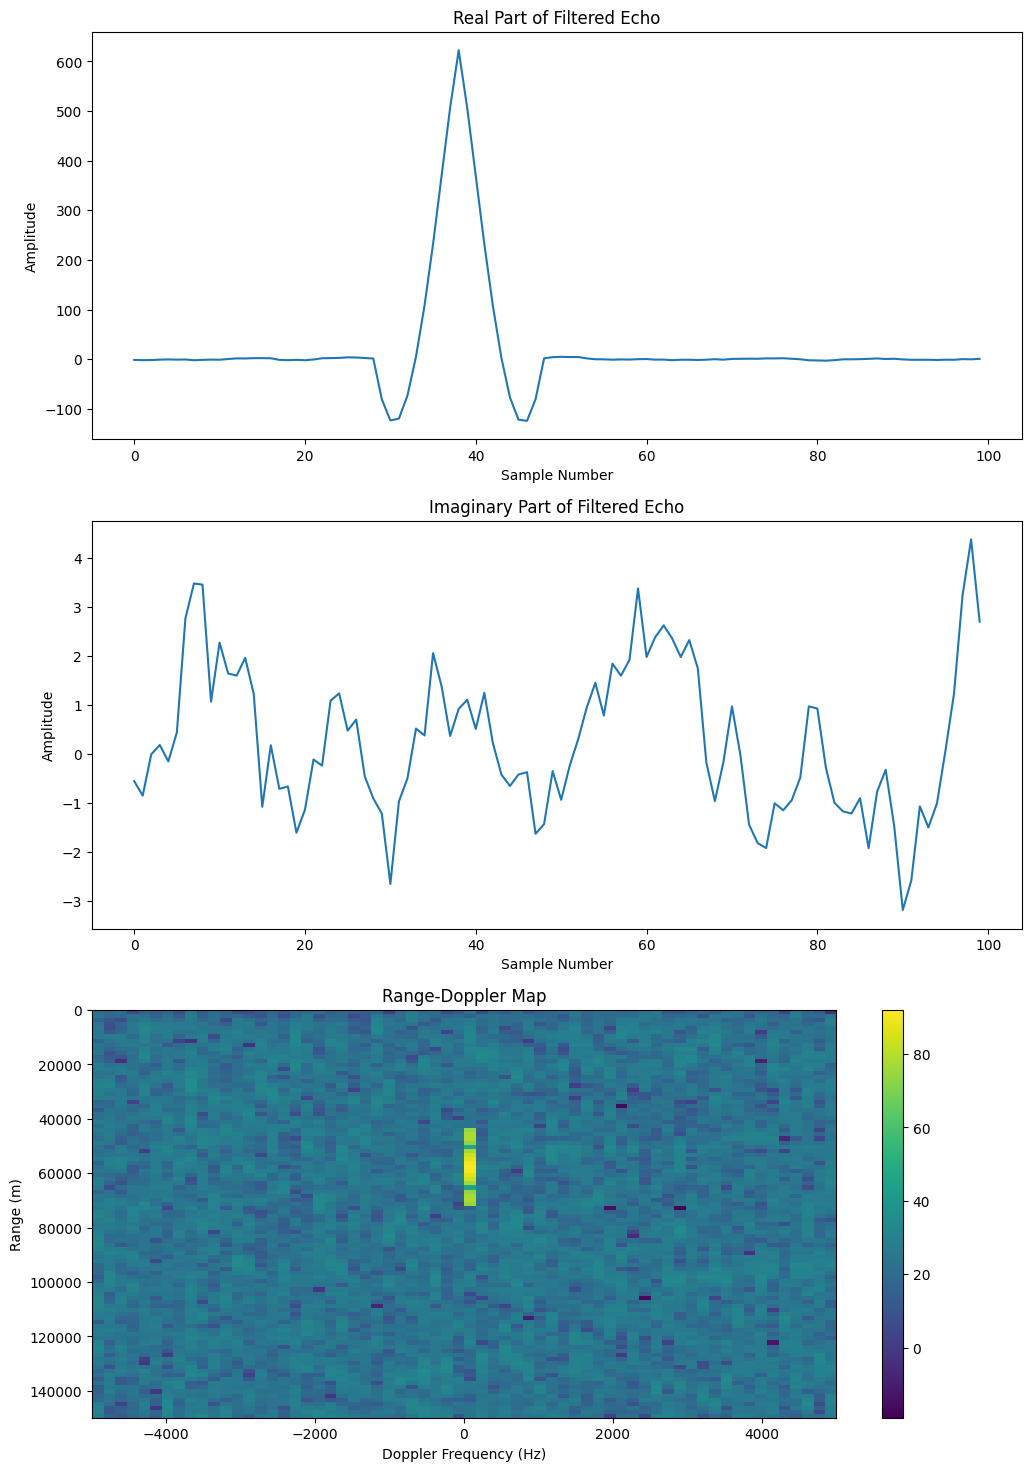

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light as c, pi
from scipy.signal import chirp, find_peaks, fftconvolve, welch

# Constants and System Parameters
fc = 3e9  # Carrier frequency: 3 GHz
fs = 1e6  # Sampling frequency: 1 MHz
c = c  # Speed of light
B = 1e5  # Sweep bandwidth: 100 kHz
Tao = 10e-6  # Pulse width: 10 microseconds
prf = 10e3  # Pulse repetition frequency: 10 kHz
num_pulses = 64  # Number of pulses
SNR = 20  # Signal-to-noise ratio: 20 dB

# Generate LFM waveform
t = np.linspace(0, Tao, int(fs * Tao), endpoint=False)
lfm_waveform = chirp(t, f0=0, f1=B, t1=Tao, method='linear') * 10**(SNR/20)

# Echo simulation
range_to_target = 5000  # in meters
delay = int(2 * range_to_target / c * fs)
echo_signals = np.zeros((int(fs/prf), num_pulses), dtype=complex)

for n in range(num_pulses):
    echo_signals[delay:delay+len(lfm_waveform), n] = lfm_waveform

# Add noise
noise_power = 1 / 10**(SNR/10)
echo_signals += np.sqrt(noise_power/2) * (np.random.normal(size=echo_signals.shape) + 1j * np.random.normal(size=echo_signals.shape))

# Matched filter
matched_filter = np.conj(np.flip(lfm_waveform))
filtered_echoes = np.array([fftconvolve(echo_signals[:, n], matched_filter, mode='same') for n in range(num_pulses)]).T

# Doppler Processing
doppler_processed = np.fft.fftshift(np.fft.fft(filtered_echoes, axis=1), axes=1)
doppler_magnitude = 20 * np.log10(np.abs(doppler_processed))

# Range-Doppler Map
range_resolution = c / (2 * B)
range_bins = np.linspace(0, range_resolution * filtered_echoes.shape[0], filtered_echoes.shape[0])
doppler_bins = np.linspace(-prf/2, prf/2, num_pulses)

# Peak detection for range estimate
integrated_pulse = np.sum(np.abs(filtered_echoes)**2, axis=1)
peaks, _ = find_peaks(integrated_pulse, height=np.max(integrated_pulse)/2)
range_estimate = range_bins[peaks[0]] if peaks.size > 0 else None

# Doppler shift and speed estimate
doppler_shift = doppler_bins[np.argmax(np.abs(doppler_processed[:, peaks[0]]))] if peaks.size > 0 else None
target_speed = doppler_shift * (c / (2 * fc)) if doppler_shift is not None else None

# Print estimates
print(f"Range Estimate: {range_estimate:.2f} m")
print(f"Doppler Shift Estimate: {doppler_shift:.2f} Hz")
print(f"Speed Estimate: {target_speed:.2f} m/s")

# Plotting
plt.figure(figsize=(12, 18))
plt.subplot(3, 1, 1)
plt.plot(np.real(filtered_echoes[:, 0]))
plt.title('Real Part of Filtered Echo')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(np.imag(filtered_echoes[:, 0]))
plt.title('Imaginary Part of Filtered Echo')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.imshow(doppler_magnitude, aspect='auto', extent=[doppler_bins[0], doppler_bins[-1], range_bins[-1], range_bins[0]])
plt.colorbar()
plt.title('Range-Doppler Map')
plt.xlabel('Doppler Frequency (Hz)')
plt.ylabel('Range (m)')
plt.show()